### Differential Equation

$\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = cos(x) + \Psi_1^2 + \Psi_2 - (1 + x^2 + sin^2(x)),$

$\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = 2x - (1 - x^2)sin(x) + \Psi_1\Psi_2,$

$\Psi_1(0) = 0, \Psi_2(0) = 1, x \in [0, 3]$

In [1]:
from typing import List, Tuple, Callable
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
import seaborn as sns

from ode_system_solver import (
    NeuralNetwork,
    mse_loss_function,
    gradient_descent,
    adam,
)
from activation_functions import elu, sigmoid, tanh, arctan

In [2]:
PSI_0 = np.array([0, 1])


def derivative(x, psi) -> np.ndarray:
    """Example #4 derivative.
    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_1_dot = np.cos(x) + psi[0] ** 2 + psi[1] - (1 + x**2 + np.sin(x) ** 2)
    psi_2_dot = 2 * x - (1 - x**2) * np.sin(x) + psi[0] * psi[1]
    return np.array([psi_1_dot, psi_2_dot])


def analytical_solution(x):
    """Analytical solution to example #4.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    psi_1 = np.sin(x)
    psi_2 = 1 + x**2

    return np.array([psi_1, psi_2])

### Training

Iteration:  0
 136.5168671944334
Iteration:  1
 120.79591609157282
Iteration:  2
 106.09262156605702
Iteration:  3
 92.41901557631635
Iteration:  4
 79.78274124759656
Iteration:  5
 68.18695921641086
Iteration:  6
 57.63005077031624
Iteration:  7
 48.106111388514336
Iteration:  8
 39.605008401441665
Iteration:  9
 32.113726689606615
Iteration:  10
 25.618430688755243
Iteration:  11
 20.10759620664571
Iteration:  12
 15.567529666923315
Iteration:  13
 11.989904103154975
Iteration:  14
 9.369132544141618
Iteration:  15
 7.671924018367995
Iteration:  16
 6.775039803199955
Iteration:  17
 6.443528693675415
Iteration:  18
 6.419806855309007
Iteration:  19
 6.521870828233115
Iteration:  20
 6.6560283184948865
Iteration:  21
 6.784622214352419
Iteration:  22
 6.896522939597578
Iteration:  23
 6.990236780568784
Iteration:  24
 7.065929789047601
Iteration:  25
 7.122199115201952
Iteration:  26
 7.155192720587589
Iteration:  27
 7.158847879032356
Iteration:  28
 7.12566682171142
Iteration:  29
 

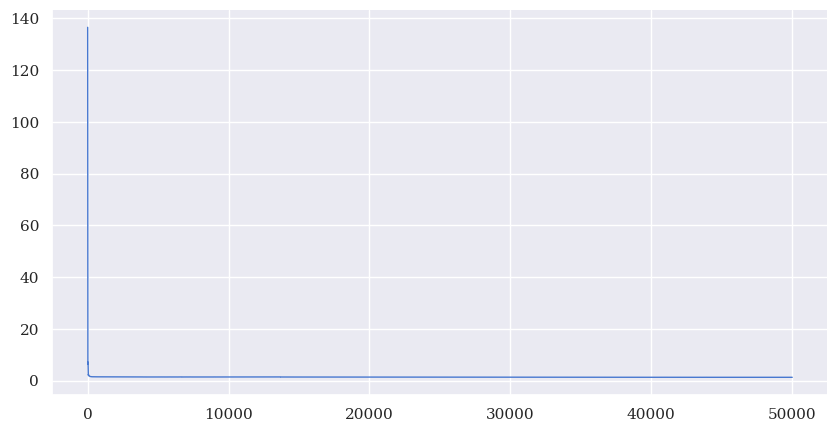

In [7]:
def train(init_conditions):
    t = np.arange(0, 3, 0.3)
    hidden_sizes = np.array([10])
    activation_fns = [elu] * (len(hidden_sizes)) + [lambda x: x]
    nn1 = NeuralNetwork(
        init_conditions[0], derivative, 1, hidden_sizes, 1, activation_fns
    )
    nn2 = NeuralNetwork(
        init_conditions[1], derivative, 1, hidden_sizes, 1, activation_fns
    )
    adam(t, [nn1, nn2], num_iters=50000, step_size=0.01)
    # gradient_descent(t, [nn1, nn2], num_iters=10000, learn_rate=0.001)

    return [nn1, nn2]


nns = train(PSI_0)

### Evaluating Results

In [5]:
def plot_ode(neural_network: NeuralNetwork, scale=1, dt=0.3):
    t = np.arange(0, 3, dt)
    res = neural_network.trial_solution(t, neural_network.weights)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    ax.plot(res[0], res[1], lw=1)
    ax.plot(analytical_solution(t)[0], analytical_solution(t)[1], lw=1)
    plt.legend(["nn", "analytical"])

    print(analytical_solution(t) - res[0])


def plot_system_ode(neural_networks: List[NeuralNetwork], scale=1, dt=0.3):
    t = np.arange(0, 3, dt)
    res = [
        neural_networks[i].trial_solution(t, neural_networks[i].weights)
        for i in range(len(neural_networks))
    ]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    ax.plot(res[0], res[1], lw=1)
    ax.plot(analytical_solution(t)[0], analytical_solution(t)[1], lw=1)
    plt.legend(["nn", "analytical"])


def simulate_sode(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
    """Simulate the system of ODEs over the time interval [0, dt * num_steps].

    Args:
       dt: The t step
       initial_conditions: The initial conditions
       num_steps: The number of t steps to calculate

    Returns:
       A tuple of two NumPy arrays: the function output values, and the derivatives.
    """
    df_dt = np.empty((len(t), len(initial_conditions)))
    output = np.empty((len(t), len(initial_conditions)))
    output[0] = initial_conditions

    for i in range(len(t) - 1):
        dt = t[i + 1] - t[i]
        output[i + 1] = output[i] + derivative(t[i], output[i]) * dt
        df_dt[i] = derivative(t[i], output[i])

    return output, df_dt

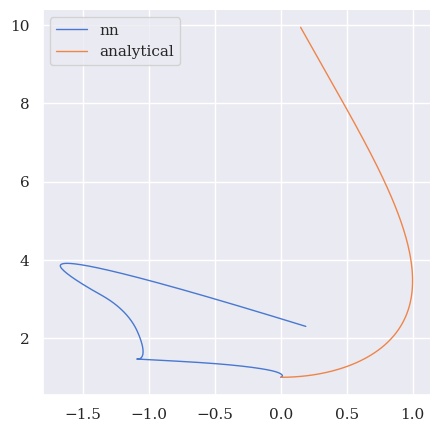

In [6]:
sns.set_theme(style="darkgrid", palette="muted", font="DeJavu Serif")
plot_system_ode(nns, dt=0.01)
sns.despine()